# Implementing Paper
- [https://www.lesswrong.com/posts/baJyjpktzmcmRfosq/stitching-saes-of-different-sizes](https://www.lesswrong.com/posts/baJyjpktzmcmRfosq/stitching-saes-of-different-sizes)
- However in case of small sae's first merge is done randomly on selecting any sae has base sae.

In [2]:
!nvidia-smi

Wed Aug 28 11:59:21 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:87:00.0 Off |                    0 |
| N/A   32C    P0             58W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
%cd /ihub/homedirs/vp_hc/neuralnexus/Mechanistic_Interpretability/manan/stitching

/ihub/homedirs/vp_hc/neuralnexus/Mechanistic_Interpretability/manan/stitching


In [4]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from huggingface_hub import hf_hub_download, notebook_login
import numpy as np
import torch

In [5]:
torch.set_grad_enabled(False) # avoid blowing up mem

model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-2b",
    device_map='auto',
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
tokenizer =  AutoTokenizer.from_pretrained("google/gemma-2-2b")

In [7]:
# The input text
prompt = "Would you be able to travel through time using a wormhole?"

# Use the tokenizer to convert it to tokens. Note that this implicitly adds a special "Beginning of Sequence" or <bos> token to the start
inputs = tokenizer.encode(prompt, return_tensors="pt", add_special_tokens=True).to("cuda")
print(inputs)

# Pass it in to the model and generate text
outputs = model.generate(input_ids=inputs, max_new_tokens=50)
print(tokenizer.decode(outputs[0]))

tensor([[     2,  18925,    692,    614,   3326,    577,   5056,   1593,   1069,
           2177,    476,  47420,  18216, 235336]], device='cuda:0')
<bos>Would you be able to travel through time using a wormhole?

[Answer 1]

Yes, you can travel through time using a wormhole.

A wormhole is a theoretical object that connects two points in space-time. It is a tunnel through space-time that allows objects to travel from


In [8]:
path_to_params_16k = hf_hub_download(
    repo_id="google/gemma-scope-2b-pt-res",
    filename="layer_20/width_16k/average_l0_71/params.npz",
    force_download=False,
)


In [9]:
path_to_params_65k = hf_hub_download(
    repo_id="google/gemma-scope-2b-pt-res",
    filename="layer_20/width_65k/average_l0_61/params.npz",
    force_download=False,
)


In [10]:
params_16k = np.load(path_to_params_16k)
pt_params_16k = {k: torch.from_numpy(v).cuda() for k, v in params_16k.items()}


In [11]:
import torch.nn as nn
class JumpReLUSAE(nn.Module):
  def __init__(self, d_model, d_sae):
    # Note that we initialise these to zeros because we're loading in pre-trained weights.
    # If you want to train your own SAEs then we recommend using blah
    super().__init__()
    self.W_enc = nn.Parameter(torch.zeros(d_model, d_sae))
    self.W_dec = nn.Parameter(torch.zeros(d_sae, d_model))
    self.threshold = nn.Parameter(torch.zeros(d_sae))
    self.b_enc = nn.Parameter(torch.zeros(d_sae))
    self.b_dec = nn.Parameter(torch.zeros(d_model))

  def encode(self, input_acts):
    pre_acts = input_acts @ self.W_enc + self.b_enc
    mask = (pre_acts > self.threshold)
    acts = mask * torch.nn.functional.relu(pre_acts)
    return acts

  def decode(self, acts):
    return acts @ self.W_dec + self.b_dec

  def forward(self, acts):
    acts = self.encode(acts)
    recon = self.decode(acts)
    return recon

In [12]:
sae_16k = JumpReLUSAE(params_16k['W_enc'].shape[0], params_16k['W_enc'].shape[1])
sae_16k.load_state_dict(pt_params_16k)

<All keys matched successfully>

In [13]:
params_65k = np.load(path_to_params_65k)
pt_params_65k = {k: torch.from_numpy(v).cuda() for k, v in params_65k.items()}


In [14]:
sae_65k = JumpReLUSAE(params_65k['W_enc'].shape[0], params_65k['W_enc'].shape[1])
sae_65k.load_state_dict(pt_params_65k)

<All keys matched successfully>

In [15]:
def gather_residual_activations(model, target_layer, inputs):
  target_act = None
  def gather_target_act_hook(mod, inputs, outputs):
    nonlocal target_act # make sure we can modify the target_act from the outer scope
    target_act = outputs[0]
    return outputs
  handle = model.model.layers[target_layer].register_forward_hook(gather_target_act_hook)
  _ = model.forward(inputs)
  handle.remove()
  return target_act

In [16]:
target_act = gather_residual_activations(model, 20, inputs)

In [17]:
sae_16k.cuda()

JumpReLUSAE()

In [18]:
sae_65k.cuda()

JumpReLUSAE()

# 16

In [19]:
sae_acts_16k = sae_16k.encode(target_act.to(torch.float32).to("cuda"))
recon_16k = sae_16k.decode(sae_acts_16k)

In [20]:
1 - torch.mean((recon_16k[:, 1:] - target_act[:, 1:].to(torch.float32).to("cuda:0")) **2) / (target_act[:, 1:].to(torch.float32).to("cuda:0").var())

tensor(0.8887, device='cuda:0')

In [21]:
(sae_acts_16k > 1).sum(-1)

tensor([[7017,   47,   65,   70,   55,   72,   65,   75,   80,   72,   68,   93,
           86,   89]], device='cuda:0')

In [22]:
sae_acts_16k

tensor([[[ 0.0000,  0.0000, 22.9148,  ...,  0.0000,  0.0000, 23.6990],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],
       device='cuda:0')

In [23]:
values, inds = sae_acts_16k.max(-1)

inds

tensor([[ 6631,  5482, 10376,  1670, 11023,  7562,  9407,  8399, 12935, 10004,
         10004, 10004, 12935,  3442]], device='cuda:0')

# 64k

In [24]:
sae_acts_65k = sae_65k.encode(target_act.to(torch.float32).to("cuda:0"))
recon_65k = sae_65k.decode(sae_acts_65k)

In [25]:
1 - torch.mean((recon_65k[:, 1:] - target_act[:, 1:].to(torch.float32).to("cuda:0")) **2) / (target_act[:, 1:].to(torch.float32).to("cuda:0").var())

tensor(0.9140, device='cuda:0')

In [26]:
(sae_acts_65k > 1).sum(-1)

tensor([[27429,    39,    55,    67,    40,    58,    62,    61,    75,    55,
            60,    69,    81,    58]], device='cuda:0')

In [27]:
sae_acts_65k

tensor([[[28.7850,  0.0000,  0.0000,  ..., 21.9794, 22.9810,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],
       device='cuda:0')

In [28]:
values, inds = sae_acts_65k.max(-1)

inds

tensor([[46637, 46149, 46552, 60101, 47747, 50661, 43719, 12157, 58426, 49575,
         62510, 51125, 58426, 61350]], device='cuda:0')

In [29]:
torch.mode(inds)

torch.return_types.mode(
values=tensor([58426], device='cuda:0'),
indices=tensor([12], device='cuda:0'))

# Stitching Them

In [30]:
def cosine_similarity_matrix(A, B):
    # Compute the dot product between A and B
    dot_product = torch.mm(A, B.T)
    
    # Compute the L2 norm of A and B
    norm_A = torch.linalg.norm(A, dim=1).unsqueeze(1)
    norm_B = torch.linalg.norm(B, dim=1).unsqueeze(0)
    
    # Compute the cosine similarity
    return dot_product / (norm_A * norm_B)

def find_novel_features_fast(small_sae, large_sae, threshold=0.7):
    # Move tensors to the same device (preferably GPU)
    device = small_sae.W_dec.device
    large_W_dec = large_sae.W_dec.to(device)
    small_W_dec = small_sae.W_dec.to(device)
    
    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity_matrix(large_W_dec, small_W_dec)
    
    # Find max similarity for each feature in large SAE
    max_similarities, _ = torch.max(similarity_matrix, dim=1)
    
    # Identify novel features
    novel_features = torch.where(max_similarities <= threshold)[0]
    
    return novel_features.tolist()

# Use the optimized function
novel_features = find_novel_features_fast(sae_16k, sae_65k)

In [31]:
novel_features

[0,
 3,
 4,
 5,
 6,
 8,
 9,
 13,
 14,
 15,
 16,
 20,
 21,
 22,
 23,
 24,
 25,
 28,
 29,
 30,
 31,
 32,
 33,
 35,
 36,
 37,
 38,
 40,
 41,
 42,
 43,
 44,
 47,
 48,
 50,
 51,
 52,
 53,
 54,
 56,
 57,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 71,
 72,
 73,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 105,
 106,
 107,
 108,
 109,
 110,
 112,
 113,
 114,
 115,
 116,
 118,
 119,
 121,
 123,
 125,
 126,
 128,
 130,
 132,
 133,
 134,
 138,
 139,
 140,
 142,
 145,
 146,
 147,
 149,
 150,
 151,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 165,
 166,
 167,
 168,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 179,
 180,
 181,
 182,
 185,
 186,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 197,
 198,
 201,
 202,
 203,
 204,
 206,
 207,
 208,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 23

In [36]:
import torch
import torch.nn as nn

class StitchedSAE(nn.Module):
    def __init__(self, base_sae, novel_features, large_sae):
        super().__init__()
        self.base_sae = base_sae
        self.novel_features = novel_features
        self.large_sae = large_sae
        
        # Select novel features from the larger SAE
        selected_W_enc = large_sae.W_enc[:, novel_features]
        selected_W_dec = large_sae.W_dec[novel_features, :]
        selected_b_enc = large_sae.b_enc[novel_features]
        selected_threshold = large_sae.threshold[novel_features]

        # Concatenate the selected features with the base SAE features
        self.W_enc = nn.Parameter(torch.cat([base_sae.W_enc, selected_W_enc], dim=1))
        self.W_dec = nn.Parameter(torch.cat([selected_W_dec, base_sae.W_dec], dim=0))
        self.b_enc = nn.Parameter(torch.cat([base_sae.b_enc, selected_b_enc]))
        self.threshold = nn.Parameter(torch.cat([base_sae.threshold, selected_threshold]))
        
        # Keep b_dec from the base SAE
        self.b_dec = nn.Parameter(base_sae.b_dec.clone())

    def encode(self, input_acts):
        pre_acts = input_acts @ self.W_enc + self.b_enc
        mask = (pre_acts > self.threshold)
        acts = mask * torch.nn.functional.relu(pre_acts)
        return acts

    def decode(self, acts):
        return acts @ self.W_dec + self.b_dec

    def forward(self, input_acts):
        acts = self.encode(input_acts)
        recon = self.decode(acts)
        return recon

# Example usage
stitched_sae = StitchedSAE(sae_16k, novel_features, sae_65k)


In [37]:
len(sae_65k.b_enc[novel_features])

50687

In [38]:
target_act = gather_residual_activations(model, 20, inputs)

In [39]:
sae_acts_final = stitched_sae.encode(target_act.to(torch.float32).to("cuda:0"))
recon_final = stitched_sae.decode(sae_acts_final)

In [40]:
1 - torch.mean((recon_final[:, 1:] - target_act[:, 1:].to(torch.float32).to("cuda:0")) **2) / (target_act[:, 1:].to(torch.float32).to("cuda:0").var())

tensor(-0.0068, device='cuda:0')

In [41]:
(sae_acts_final > 1).sum(-1)

tensor([[27989,    67,    95,   107,    77,   102,    95,   107,   118,   101,
           106,   134,   120,   118]], device='cuda:0')

In [42]:
import torch.nn as nn
mse_loss = nn.MSELoss()
loss = mse_loss(recon_65k, target_act)

In [43]:
loss

tensor(142938.5938, device='cuda:0')

In [44]:
for param in stitched_sae.parameters():
    param.requires_grad = True

In [45]:
torch.set_grad_enabled(True) # avoid blowing up mem


# Retraining the decoder

In [72]:
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from transformers import AutoTokenizer

# Load a subset of the Pile dataset
dataset = load_dataset("roneneldan/TinyStoriesInstruct", split="train[:1%]")  # Using 1% of the data for example

# Initialize the tokenizer (use the same one you used for your original model)

# Prepare the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=dataset.column_names)

# Convert to PyTorch tensors
tokenized_dataset.set_format("torch")

# Create DataLoader
batch_size = 32  # Adjust as needed
data_loader = DataLoader(tokenized_dataset, batch_size=batch_size, shuffle=True)

# Modify the retrain_decoder function
def retrain_decoder(model, original_model, data_loader, num_epochs=10, lr=4e-4):
    device = next(model.parameters()).device
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    for epoch in range(num_epochs):
        total_loss = 0
        i = 0
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            
            # Get the residual activations
            with torch.no_grad():
                target_act = gather_residual_activations(original_model, 20, input_ids)
            
            optimizer.zero_grad()
            recon = model(target_act)
            loss = criterion(recon, target_act)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            if(i%4==0):
                print(f"Loss: {loss.item():.4f}")
            i+=1
        
        avg_loss = total_loss / len(data_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

# Retrain the decoder
retrain_decoder(stitched_sae, model, data_loader)

Map:   0%|          | 0/217557 [00:00<?, ? examples/s]

Loss: 1.5859
Loss: 4.2827
Loss: 1.5279
Loss: 1.5367
Loss: 1.2315
Loss: 1.1508
Loss: 1.0740
Loss: 0.8567
Loss: 0.7588
Loss: 0.8065
Loss: 0.6306
Loss: 0.7185
Loss: 0.7896
Loss: 0.6336
Loss: 0.4765
Loss: 0.5413
Loss: 0.6631
Loss: 0.6829
Loss: 0.5682
Loss: 0.4396
Loss: 0.4587
Loss: 0.5392
Loss: 0.6555
Loss: 0.4951
Loss: 0.6036
Loss: 0.4669
Loss: 0.5277
Loss: 0.4178
Loss: 0.4261
Loss: 0.3088
Loss: 0.3227
Loss: 0.5123
Loss: 0.3839
Loss: 0.5437
Loss: 0.3682
Loss: 0.3850
Loss: 0.4927
Loss: 0.5469
Loss: 0.3960
Loss: 0.4159
Loss: 0.4967
Loss: 0.4196
Loss: 0.4643
Loss: 0.5103
Loss: 0.4192
Loss: 0.4468
Loss: 0.4442
Loss: 0.5393
Loss: 0.4432
Loss: 0.3236
Loss: 0.5822
Loss: 0.2906
Loss: 0.4877
Loss: 0.4201
Loss: 0.3595
Loss: 0.4237
Loss: 0.3909
Loss: 0.3125
Loss: 0.4085
Loss: 0.4747
Loss: 0.3706
Loss: 0.3072
Loss: 0.4050
Loss: 0.4553
Loss: 0.3265
Loss: 0.4123
Loss: 0.3584
Loss: 0.3825
Loss: 0.3493
Loss: 0.3762
Loss: 0.3349
Loss: 0.3320
Loss: 0.2937
Loss: 0.4525
Loss: 0.3775
Loss: 0.3057
Loss: 0.2739

KeyboardInterrupt: 

In [80]:
w = stitched_sae(target_act)

In [81]:
with torch.no_grad():
    l = nn.MSELoss()
    print(l(w, target_act).item())

6060.849609375


In [82]:
# save stitched model
torch.save(stitched_sae.state_dict(), "/ihub/homedirs/vp_hc/neuralnexus/Mechanistic_Interpretability/stitched_sae_fine.pth")

In [68]:
# load stitched model from saved pth
stitched_sae.load_state_dict(torch.load("/ihub/homedirs/vp_hc/neuralnexus/Mechanistic_Interpretability/stitched_sae.pth"))


<All keys matched successfully>

# Training SAE

In [ ]:
from sae_lens import LanguageModelSAERunnerConfig, SAETrainingRunner
from transformer_lens import HookedTransformer

model = HookedTransformer.from_pretrained(
    "gemma-2-2b"
)  # This will wrap huggingface models and has lots of nice utilities.

In [ ]:
total_training_steps = 30_000  # probably we should do more
batch_size = 8
total_training_tokens = total_training_steps * batch_size

lr_warm_up_steps = 0
lr_decay_steps = total_training_steps // 5  # 20% of training
l1_warm_up_steps = total_training_steps // 20  # 5% of training

cfg = LanguageModelSAERunnerConfig(
    # Data Generating Function (Model + Training Distibuion)
    model_name="gemma-2-2b",  # our model (more options here: https://neelnanda-io.github.io/TransformerLens/generated/model_properties_table.html)
    hook_name="blocks.20.hook_mlp_out",  # A valid hook point (see more details here: https://neelnanda-io.github.io/TransformerLens/generated/demos/Main_Demo.html#Hook-Points)
    hook_layer=20,  # Only one layer in the model.
    d_in=2304,  # the width of the mlp output.
    dataset_path="sebastiandizon/spotify-million-song",  # this is a tokenized language dataset on Huggingface for the Tiny Stories corpus.
    is_dataset_tokenized=True,
    streaming=True,  # we could pre-download the token dataset if it was small.
    # SAE Parameters
    mse_loss_normalization=None,  # We won't normalize the mse loss,
    expansion_factor=4,  # the width of the SAE. Larger will result in better stats but slower training.
    b_dec_init_method="zeros",  # The geometric median can be used to initialize the decoder weights.
    apply_b_dec_to_input=False,  # We won't apply the decoder weights to the input.
    normalize_sae_decoder=False,
    scale_sparsity_penalty_by_decoder_norm=True,
    decoder_heuristic_init=True,
    init_encoder_as_decoder_transpose=True,
    normalize_activations="expected_average_only_in",
    # Training Parameters
    lr=5e-4,  # lower the better, we'll go fairly high to speed up the tutorial.
    adam_beta1=0.9,  # adam params (default, but once upon a time we experimented with these.)
    adam_beta2=0.999,
    lr_scheduler_name="constant",  # constant learning rate with warmup. Could be better schedules out there.
    lr_warm_up_steps=lr_warm_up_steps,  # this can help avoid too many dead features initially.
    lr_decay_steps=lr_decay_steps,  # this will help us avoid overfitting.
    l1_coefficient=5,  # will control how sparse the feature activations are
    l1_warm_up_steps=l1_warm_up_steps,  # this can help avoid too many dead features initially.
    lp_norm=1.0,  # the L1 penalty (and not a Lp for p < 1)
    train_batch_size_tokens=batch_size,
    context_size=512,  # will control the lenght of the prompts we feed to the model. Larger is better but slower. so for the tutorial we'll use a short one.
    # Activation Store Parameters
    n_batches_in_buffer=32,  # controls how many activations we store / shuffle.
    training_tokens=total_training_tokens,  # 100 million tokens is quite a few, but we want to see good stats. Get a coffee, come back.
    store_batch_size_prompts=16,
    # Resampling protocol
    use_ghost_grads=False,  # we don't use ghost grads anymore.
    feature_sampling_window=1000,  # this controls our reporting of feature sparsity stats
    dead_feature_window=1000,  # would effect resampling or ghost grads if we were using it.
    dead_feature_threshold=1e-4,  # would effect resampling or ghost grads if we were using it.
    # WANDB
    log_to_wandb=True,  # always use wandb unless you are just testing code.
    wandb_project="sae_lens_tutorial",
    wandb_log_frequency=30,
    eval_every_n_wandb_logs=20,
    # Misc
    device=device,
    seed=42,
    n_checkpoints=1,
    checkpoint_path="checkpoints",
    dtype="float32"
)
# look at the next cell to see some instruction for what to do while this is running.
sparse_autoencoder = SAETrainingRunner(cfg).run()

# MULTIPLE SMALL SAES TRAINED ON CODE, TINY STORIES AND SPOTIFY MUSIC LYRICS ARE STITCHED TOGETHER

In [3]:
!pip install sae-lens transformer-lens sae-dashboard

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import os
import torch
from tqdm import tqdm
import plotly.express as px

# Imports for displaying vis in Colab / notebook
import webbrowser
import http.server
import socketserver
import threading
PORT = 8000

torch.set_grad_enabled(False);

In [2]:
if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda:1" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

Device: cuda:1


In [3]:
def display_vis_inline(filename: str, height: int = 850):
    '''
    Displays the HTML files in Colab. Uses global `PORT` variable defined in prev cell, so that each
    vis has a unique port without having to define a port within the function.
    '''
    webbrowser.open(filename)

In [4]:
from datasets import load_dataset  
from transformer_lens import HookedTransformer
from sae_lens import SAE

model = HookedTransformer.from_pretrained("gemma-2-2b", device = device)

# the cfg dict is returned alongside the SAE since it may contain useful information for analysing the SAE (eg: instantiating an activation store)
# Note that this is not the same as the SAEs config dict, rather it is whatever was in the HF repo, from which we can extract the SAE config dict
# We also return the feature sparsities which are stored in HF for convenience. 
sae = SAE.load_from_pretrained(
    path = "/ihub/homedirs/vp_hc/neuralnexus/Mechanistic_Interpretability/manan/stitching/checkpoints/46ygoibk/final_960000",
    device = device,
    
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b into HookedTransformer


In [5]:
from transformer_lens.utils import tokenize_and_concatenate

dataset = load_dataset(
    path = "benyang123/code",
    split="train",
    streaming=False,
)

token_dataset = tokenize_and_concatenate(
    dataset= dataset,# type: ignore
    tokenizer = model.tokenizer, # type: ignore
    streaming=True,
    max_length=sae.cfg.context_size,
    add_bos_token=sae.cfg.prepend_bos,
)

Repo card metadata block was not found. Setting CardData to empty.


In [10]:
sae2 = SAE.load_from_pretrained(
    path = "/ihub/homedirs/vp_hc/neuralnexus/Mechanistic_Interpretability/manan/stitching/checkpoints/2tovm2vw/final_240000",
    device = device,
)

In [8]:
import torch
torch.cuda.empty_cache()

In [9]:
import gc
gc.collect()

1507

In [14]:
def cosine_similarity_matrix(A, B):
    # Compute the dot product between A and B
    dot_product = torch.mm(A, B.T)
    
    # Compute the L2 norm of A and B
    norm_A = torch.linalg.norm(A, dim=1).unsqueeze(1)
    norm_B = torch.linalg.norm(B, dim=1).unsqueeze(0)
    
    # Compute the cosine similarity
    return dot_product / (norm_A * norm_B)

def find_novel_features_fast(small_sae, large_sae, threshold=0.7):
    # Move tensors to the same device (preferably GPU)
    device = small_sae.W_dec.device
    large_W_dec = large_sae.W_dec.to(device)
    small_W_dec = small_sae.W_dec.to(device)
    
    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity_matrix(large_W_dec, small_W_dec)
    
    # Find max similarity for each feature in large SAE
    max_similarities, _ = torch.max(similarity_matrix, dim=1)
    
    # Identify novel features
    novel_features = torch.where(max_similarities <= threshold)[0]
    
    return novel_features.tolist()

# Use the optimized function
novel_features = find_novel_features_fast(sae2, sae)

In [126]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def cosine_similarity_matrix(A, B):
    with torch.no_grad():
        dot_product = torch.mm(A, B.T)
        norm_A = torch.linalg.norm(A, dim=1).unsqueeze(1)
        norm_B = torch.linalg.norm(B, dim=1).unsqueeze(0)
        return dot_product / (norm_A * norm_B)

def mock_anthropic_metric(similarity):
    # This is a mock function to simulate an anthropic metric
    # It creates a noisy relationship with cosine similarity
    with torch.no_grad():
        return similarity + np.random.normal(0, 0.1, similarity.shape)

def plot_similarity_comparison(small_sae, large_sae):
    device = small_sae.W_dec.device
    large_W_dec = large_sae.W_dec.to(device)
    small_W_dec = small_sae.W_dec.to(device)
    
    with torch.no_grad():
        similarity_matrix = cosine_similarity_matrix(large_W_dec, small_W_dec)
        # Convert to numpy for easier plotting
        cosine_sim = similarity_matrix.cpu().detach().numpy().flatten()
        
        # Calculate mock anthropic metric
        anthropic_metric = mock_anthropic_metric(cosine_sim)
        
        # Create the plot
        plt.figure(figsize=(10, 8))
        plt.scatter(cosine_sim, anthropic_metric, alpha=0.1)
        plt.xlabel('Cosine Similarity')
        plt.ylabel('Anthropic Metric')
        plt.title('Comparison of Cosine Similarity and Anthropic Metric')
        
        # Add linear regression line for cosine similarity > 0.5
        mask = cosine_sim > 0.5
        slope, intercept, r_value, p_value, std_err = stats.linregress(cosine_sim[mask], anthropic_metric[mask])
        line = slope * cosine_sim[mask] + intercept
        plt.plot(cosine_sim[mask], line, color='red', label=f'Linear Regression on > 0.5')
        
        plt.legend()
        plt.tight_layout()
        plt.savefig('similarity_comparison.png')
        plt.close()

# Use the function
plot_similarity_comparison(sae2, sae)

/tmp/ipykernel_132773/3635387642.py:46: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/tmp/ipykernel_132773/3635387642.py:47: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



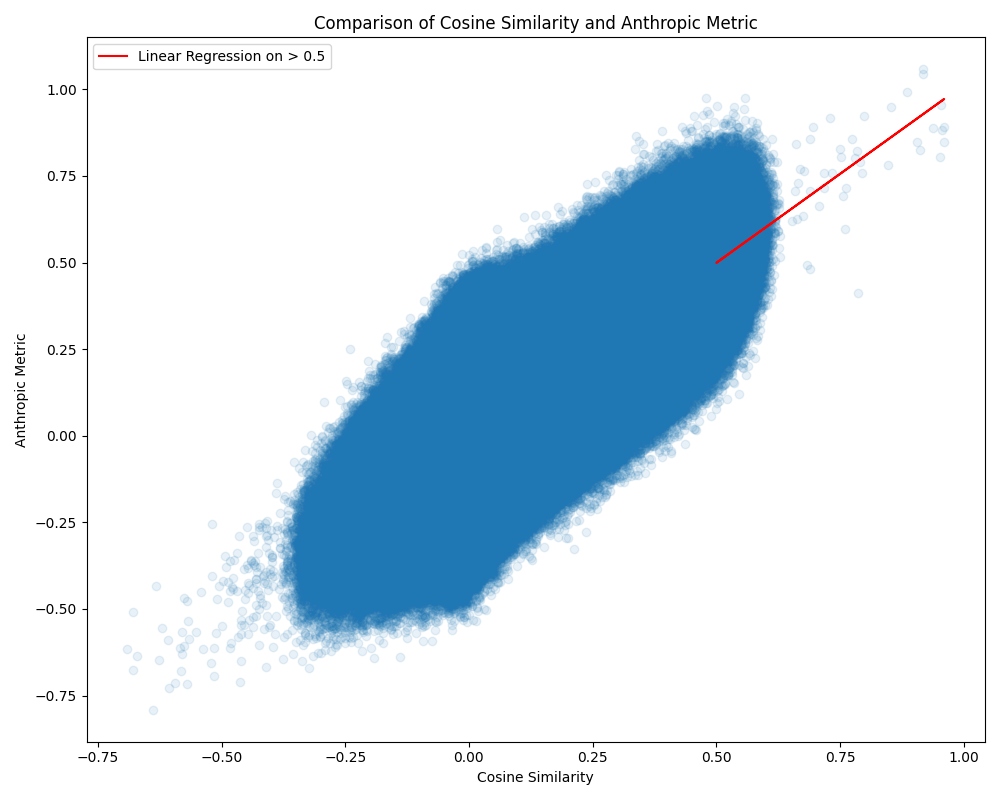

In [147]:
from PIL import Image
Image.open('/ihub/homedirs/vp_hc/neuralnexus/Mechanistic_Interpretability/manan/stitching/similarity_comparison.png')

In [15]:
len(novel_features)

9202

In [21]:
import torch
import torch.nn as nn

class StitchedSAE(nn.Module):
    def __init__(self, base_sae, novel_features, large_sae):
        super().__init__()
        self.base_sae = base_sae
        self.novel_features = novel_features
        self.large_sae = large_sae
        
        # Select novel features from the larger SAE
        selected_W_enc = large_sae.W_enc[:, novel_features]
        selected_W_dec = large_sae.W_dec[novel_features, :]
        selected_b_enc = large_sae.b_enc[novel_features]

        # Concatenate the selected features with the base SAE features
        self.W_enc = nn.Parameter(torch.cat([base_sae.W_enc, selected_W_enc], dim=1))
        self.W_dec = nn.Parameter(torch.cat([selected_W_dec, base_sae.W_dec], dim=0))
        self.b_enc = nn.Parameter(torch.cat([base_sae.b_enc, selected_b_enc]))
        
        # Keep b_dec from the base SAE
        self.b_dec = nn.Parameter(base_sae.b_dec.clone())

    def encode(self, input_acts):
        pre_acts = input_acts @ self.W_enc + self.b_enc
        # mask = (pre_acts > self.threshold)
        acts = torch.nn.functional.relu(pre_acts)
        return acts

    def decode(self, acts):
        return acts @ self.W_dec + self.b_dec

    def forward(self, input_acts):
        acts = self.encode(input_acts)
        recon = self.decode(acts)
        return recon

# Example usage
stitched_sae = StitchedSAE(sae2, novel_features, sae)


In [25]:
sae3 = SAE.load_from_pretrained(
    path = "/ihub/homedirs/vp_hc/neuralnexus/Mechanistic_Interpretability/manan/stitching/checkpoints/zmyzn0ox/final_240000",
    device = device,
)

In [26]:
novel_features = find_novel_features_fast(sae3, stitched_sae)

In [27]:
len(novel_features)

18351

In [28]:
final_sae = StitchedSAE(sae3, novel_features, stitched_sae)


StitchedSAE(
  (base_sae): SAE(
    (activation_fn): ReLU()
    (hook_sae_input): HookPoint()
    (hook_sae_acts_pre): HookPoint()
    (hook_sae_acts_post): HookPoint()
    (hook_sae_output): HookPoint()
    (hook_sae_recons): HookPoint()
    (hook_sae_error): HookPoint()
  )
  (large_sae): StitchedSAE(
    (base_sae): SAE(
      (activation_fn): ReLU()
      (hook_sae_input): HookPoint()
      (hook_sae_acts_pre): HookPoint()
      (hook_sae_acts_post): HookPoint()
      (hook_sae_output): HookPoint()
      (hook_sae_recons): HookPoint()
      (hook_sae_error): HookPoint()
    )
    (large_sae): SAE(
      (activation_fn): ReLU()
      (hook_sae_input): HookPoint()
      (hook_sae_acts_pre): HookPoint()
      (hook_sae_acts_post): HookPoint()
      (hook_sae_output): HookPoint()
      (hook_sae_recons): HookPoint()
      (hook_sae_error): HookPoint()
    )
  )
)

In [33]:
import torch
torch.cuda.empty_cache()

In [34]:
import gc
gc.collect()

7701

In [38]:
torch.save(stitched_sae.state_dict(), "/ihub/homedirs/vp_hc/neuralnexus/Mechanistic_Interpretability/manan/stitching/final_sae.pth")

In [43]:

def gather_residual_activations(model, target_layer, inputs):
  target_act = None
  def gather_target_act_hook(mod, inputs, outputs):
    nonlocal target_act # make sure we can modify the target_act from the outer scope
    target_act = outputs[0]
    return outputs
  handle = model.blocks[target_layer].register_forward_hook(gather_target_act_hook)
  _ = model.forward(inputs)
  handle.remove()
  return target_act

In [87]:
prompt = "Round and round up and below please tell me whats is the loss hello"
# Use the tokenizer to convert it to tokens. Note that this implicitly adds a special "Beginning of Sequence" or <bos> token to the start
inputs = model.tokenizer.encode(prompt, return_tensors="pt", add_special_tokens=True).to("cuda")
print(inputs)

tensor([[    2, 20067,   578,  5094,   908,   578,  3582,  3743,  3337,   682,
         68722,   603,   573,  4783, 25612]], device='cuda:0')


In [88]:
target_act = gather_residual_activations(model, 20, inputs)

In [89]:
target_act

tensor([[  1.9440,   1.7632,  -2.0879,  ...,   1.6978,  -2.0868,  -0.0178],
        [ -2.4960,   3.3304,  -3.6535,  ...,   7.6643,  -0.5127,  -4.1403],
        [  8.4462,   6.6839,  -3.3057,  ...,  -2.2114,   9.3886,   2.5396],
        ...,
        [  5.5931,   2.8202,   3.0233,  ...,  -1.1374,   1.5230,  -9.5033],
        [-10.5751,  -1.8705,  -5.0490,  ...,   1.9793,  -0.8888,  -4.7185],
        [ -7.0346,   1.8667,   4.4238,  ...,   3.6044,   6.1262,  -1.8282]],
       device='cuda:1', grad_fn=<SelectBackward0>)

In [90]:
sae_acts = final_sae.encode(target_act.to(torch.float32).to('cuda:1'))
recon = final_sae.decode(sae_acts)

In [95]:
recon

tensor([[ 2.0950, -2.1099,  0.7696,  ...,  3.6022, -5.4767,  0.1511],
        [-2.9953,  2.3549,  0.0635,  ...,  3.4536,  2.7754,  1.6411],
        [ 2.3583,  0.4293,  1.9903,  ...,  0.5821,  4.8355,  1.6806],
        ...,
        [-0.5989,  2.6744,  3.3642,  ..., -1.4132,  2.0943, -2.8118],
        [-3.4010,  0.7978,  0.8873,  ...,  0.2484,  1.0567, -1.4042],
        [-4.6785,  1.1023,  1.8207,  ..., -1.6373,  3.5589,  0.1401]],
       device='cuda:1', grad_fn=<AddBackward0>)

In [91]:
1 - torch.mean((recon[:, 1:] - target_act[:, 1:].to(torch.float32).to('cuda:1')) **2) / (target_act[:, 1:].to(torch.float32).to('cuda:1').var())

tensor(0.9292, device='cuda:1', grad_fn=<RsubBackward1>)

In [92]:
(sae_acts > 1).sum(-1)

tensor([1765,  413,  384,  509,  531,  424,  518,  505,  498,  454,  461,  461,
         455,  450,  420], device='cuda:1')

In [93]:
import torch.nn as nn
mse_loss = nn.MSELoss()
loss = mse_loss(recon, target_act)

In [94]:
loss

tensor(20.8007, device='cuda:1', grad_fn=<MseLossBackward0>)

In [67]:
torch.set_grad_enabled(True) # avoid blowing up mem

In [68]:
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from transformers import AutoTokenizer

# Load a subset of the Pile dataset
dataset = load_dataset("NeelNanda/pile-10k", split="train")  # Using 1% of the data for example

# Initialize the tokenizer (use the same one you used for your original model)

# Prepare the dataset
def tokenize_function(examples):
    return model.tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=dataset.column_names)

# Convert to PyTorch tensors
tokenized_dataset.set_format("torch")

# Create DataLoader
batch_size = 8  # Adjust as needed
data_loader = DataLoader(tokenized_dataset, batch_size=batch_size, shuffle=True)

# Modify the retrain_decoder function
def retrain_decoder(model, original_model, data_loader, num_epochs=10, lr=4e-4):
    device = next(model.parameters()).device
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    for epoch in range(num_epochs):
        total_loss = 0
        i = 0
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            
            # Get the residual activations
            with torch.no_grad():
                target_act = gather_residual_activations(original_model, 20, input_ids)
            
            optimizer.zero_grad()
            recon = model(target_act)
            loss = criterion(recon, target_act)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            if(i%4==0):
                print(f"Loss: {loss.item():.4f}")
            i+=1
        
        avg_loss = total_loss / len(data_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

# Retrain the decoder
retrain_decoder(final_sae, model, data_loader)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Loss: 91.2643
Loss: 26.3211
Loss: 47.8940
Loss: 47.0471
Loss: 30.9942
Loss: 40.4978
Loss: 33.0578
Loss: 38.1030
Loss: 26.5265
Loss: 29.4292
Loss: 31.8945
Loss: 31.6390
Loss: 33.2495
Loss: 21.4763
Loss: 12.6822
Loss: 5.6777
Loss: 28.8090
Loss: 31.6427
Loss: 5.9232
Loss: 28.8418
Loss: 23.9741
Loss: 27.5956
Loss: 25.1494
Loss: 13.6396
Loss: 26.1393
Loss: 10.0493
Loss: 17.1408
Loss: 4.5424
Loss: 14.2519
Loss: 14.6407
Loss: 16.3060
Loss: 24.6629
Loss: 20.5499
Loss: 23.8143
Loss: 3.9614
Loss: 6.6096
Loss: 9.5108
Loss: 13.9734
Loss: 16.8957
Loss: 7.3295
Loss: 24.7422
Loss: 24.8846
Loss: 24.2371
Loss: 23.4407
Loss: 13.9853
Loss: 10.2582
Loss: 24.0947
Loss: 5.7036
Loss: 2.4405
Loss: 3.2757
Loss: 3.1000
Loss: 1.9263
Loss: 23.0878
Loss: 21.6579
Loss: 21.4319
Loss: 22.5808
Loss: 5.0258


KeyboardInterrupt: 

In [98]:
with torch.no_grad():
    # activation store can give us tokens.
    batch_tokens = token_dataset[:5]["tokens"]
    _, cache = model.run_with_cache(batch_tokens, prepend_bos=True)

    # Use the SAE
    feature_acts = final_sae.encode(cache[sae.cfg.hook_name])
    sae_out = final_sae.decode(feature_acts)

    # save some room
    del cache

    # ignore the bos token, get the number of features that activated in each token, averaged accross batch and position
    l0 = (feature_acts[:, 1:] > 0).float().sum(-1).detach()
    print("average l0", l0.mean().item())
    px.histogram(l0.flatten().cpu().numpy()).show()

average l0 398.17144775390625


In [ ]:
# even though average l0 is increased on actual tasks the loss in reconsturction is reduced

In [97]:
torch.save(final_sae.state_dict(), "/ihub/homedirs/vp_hc/neuralnexus/Mechanistic_Interpretability/manan/stitching/final_sae_trained.pth")

In [99]:
import torch
torch.cuda.empty_cache()

In [100]:
import gc
gc.collect()

11953

In [108]:
data = load_dataset("NeelNanda/c4-code-20k", split="train")
tokenized_data = tokenize_and_concatenate(data, model.tokenizer, max_length=512)
tokenized_data = tokenized_data.shuffle(42)
all_tokens = tokenized_data["tokens"]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map (num_proc=10):   0%|          | 0/20000 [00:00<?, ? examples/s]

In [113]:
for k, v in final_sae.named_parameters():
    print(f"{k}: {tuple(v.shape)}")

W_enc: (2304, 27567)
W_dec: (27567, 2304)
b_enc: (27567,)
b_dec: (2304,)
base_sae.b_enc: (9216,)
base_sae.W_dec: (9216, 2304)
base_sae.W_enc: (2304, 9216)
base_sae.b_dec: (2304,)
large_sae.W_enc: (2304, 18418)
large_sae.W_dec: (18418, 2304)
large_sae.b_enc: (18418,)
large_sae.b_dec: (2304,)
large_sae.base_sae.b_enc: (9216,)
large_sae.base_sae.W_dec: (9216, 2304)
large_sae.base_sae.W_enc: (2304, 9216)
large_sae.base_sae.b_dec: (2304,)
large_sae.large_sae.b_enc: (9216,)
large_sae.large_sae.W_dec: (9216, 2304)
large_sae.large_sae.W_enc: (2304, 9216)
large_sae.large_sae.b_dec: (2304,)


In [114]:
from dataclasses import dataclass

@dataclass
class SAEConfig:
    d_hidden: int
    d_in: int

# Create the config object
cfg = SAEConfig(
    d_hidden=final_sae.W_enc.shape[1],  # Fill in appropriate value
    d_in=final_sae.W_enc.shape[0]
)

In [115]:
final_sae.cfg = cfg

In [117]:
final_sae.W_dec.shape

torch.Size([27567, 2304])

In [116]:
final_sae.cfg

SAEConfig(d_hidden=27567, d_in=2304)